In [1]:
import cdsapi
import os

folder_cds_data = "cds_Data"
folder_excel_data = "example_data"
############################## Basic Settings ############################ 
new_download = True   

# # ############################# Solarpark_xy ############################
# location = 'Solarpark_xy' 
# lat = 52.5931
# lon = 12.031519
# year = ['2022']
# excel_input = os.path.join(folder_excel_data,'Solarpark_xy_energiedaten_viertelstunde_kw_2022-01-01_2022-12-31.xlsx' ) 
# TODO get sample data

surface_tilt = 15.0
surface_azimuth = 180.0	

point = str(lat) + '/' + str(lon) + '/' + str(lat) + '/' + str(lon)

# create a client object
c = cdsapi.Client()

# define the request parameters
months = [str(i).zfill(2) for i in range(1, 13)] # put end to 13 for full year
days = [str(i).zfill(2) for i in range(1, 32)]
variables_list = ['2m_temperature',
                '10m_u_component_of_wind', 
                '10m_v_component_of_wind',
                'surface_net_solar_radiation', 
                'surface_solar_radiation_downwards',
                'total_cloud_cover',
                'forecast_albedo',
                'surface_pressure']

# define the output file name by year day and month 
downloaded_file = location+'_ERA5-Reanalysis_' + year[0] + months[0] + days[0] +'_till_' + year[0] + months[-1] + days[-1] + '_radiation.nc'
downloaded_file = os.path.join(folder_cds_data, downloaded_file)

if new_download == True:
    # send the request to the CDS server
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'year': year,
            'month': months,
            'day': days,
            'time': [
        
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',],
            'variable': variables_list,
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'area': point, # extract data for a single point
            #'LEVELIST': '10/25/50/75/100', # specify the desired levels in meters
        },
        downloaded_file
    )


2023-07-13 12:40:48,000 INFO Welcome to the CDS
2023-07-13 12:40:48,002 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-07-13 12:40:48,165 INFO Request is queued
2023-07-13 12:40:49,226 INFO Request is running
2023-07-13 13:35:13,302 INFO Request is completed
2023-07-13 13:35:13,304 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data1/adaptor.mars.internal-1689247677.587385-21312-19-e881d86f-3a48-4c7d-bc1f-6496d5bd26d2.nc to C:\Users\MatthiasReif\OneDrive - node energy GmbH\Dokumente\PPA_stuff\AE Analyse\Backcasts_ERA5\cds_Data\Solarpark_Schoenhausen_ERA5-Reanalysis_20220101_till_20221231_radiation.nc (174.1K)
2023-07-13 13:35:13,686 INFO Download rate 455.4K/s


In [2]:
import netCDF4 as nc
import datetime
import matplotlib.pyplot as plt

# read the downloaded file
data = nc.Dataset(downloaded_file, 'r')

# print a list of variables which are in the file
# print(data.variables.keys())

# extract the data using the keys we just printed
time = data.variables['time'][:] # time
u10 = data.variables['u10'][:] # 10m_u_component_of_wind
v10 = data.variables['v10'][:] # 10m_v_component_of_wind 
t2m = data.variables['t2m'][:] # 2m_temperature
ssr = data.variables['ssr'][:] # surface_net_solar_radiation
ssrd = data.variables['ssrd'][:] # surface_solar_radiation_downwards
tcc = data.variables['tcc'][:] # total_cloud_cover 
fal = data.variables['fal'][:] # forecast_albedo
sp = data.variables['sp'][:] # surface_pressure

# close the file
data.close()

# convert time to list of datetime objects
dates = []
for t in time:
    date = datetime.datetime(1900, 1, 1) + datetime.timedelta(hours=int(t))
    dates.append(date)

In [3]:
import pandas as pd

df_power_hist = pd.read_excel(excel_input)
df_power_hist = df_power_hist.rename(columns={df_power_hist.columns[0]: 'datetime',df_power_hist.columns[1]: 'real_power'})

# convert datetime to UTC timezone aware datetime
df_power_hist['datetime'] = pd.to_datetime(df_power_hist['datetime'], utc=True)

# convert to the desired timezone
df_power_hist['datetime'] = df_power_hist['datetime'].dt.tz_convert('Europe/Berlin')

# Group by hour and calculate mean of the four 15-minute values, seperately for each column
df_power_hist_hourly = df_power_hist.groupby(pd.Grouper(key='datetime', freq='1H')).mean()


ParserError: Unknown string format: Zeit von present at position 5

In [ ]:
import pandas as pd
import numpy as np
import pvlib

# Define the timezone of the PV system
timezone = 'Europe/Berlin'

# Create a pandas DataFrame to hold the ERA5 data
era5_data = pd.DataFrame({
    'time': dates,
    'wind_speed_10m': (u10.flatten()**2 + v10.flatten()**2)**0.5,
    'temp_air': t2m.flatten()-273.15,
    'ghi': ssrd.flatten() / 3600,  # convert from J/m^2 to W/m^2
    'dhi': (ssrd - ssr).flatten() / 3600,  # convert from J/m^2 to W/m^2
    'dni': pvlib.irradiance.get_extra_radiation(time).flatten() / 3600,  # convert from J/m^2 to W/m^2
    'total_clouds': tcc.flatten() * 100.0,
    'albedo': fal.flatten(),
    'pressure': sp.flatten()
})


# set time to index in era5_data
era5_data.set_index('time', inplace=True)

# Convert the DataFrame to a PVLib Location object
location_pv = pvlib.location.Location(lat, lon, tz=timezone)

solar_position = location_pv.get_solarposition(era5_data.index)

# Calculate the plane of array irradiance
poa_irradiance = pvlib.irradiance.get_total_irradiance(
                surface_tilt=surface_tilt, 
                surface_azimuth=surface_azimuth, 
                dni=era5_data['dni'],  
                ghi=era5_data['ghi'], 
                dhi=era5_data['dhi'],
                solar_zenith=solar_position['apparent_zenith'],
                solar_azimuth=solar_position['azimuth'])

    # total_clouds=era5_data['total_clouds'], 
    # temp_air=era5_data['temp_air'], 
    # pressure=era5_data['pressure'], 
    # albedo=era5_data['albedo']

poa_irradiance.max()





poa_global            147.031127
poa_direct              0.392425
poa_diffuse           146.654545
poa_sky_diffuse       132.266612
poa_ground_diffuse     14.528712
dtype: float64

In [ ]:
parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
cell_temperature = pvlib.temperature.sapm_cell(poa_irradiance['poa_global'],
                                               era5_data['temp_air'],
                                               era5_data['wind_speed_10m'],
                                               **parameters)

# all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
# list(all_parameters.keys())

In [ ]:
# era5_data['temp_air'].head(24*7).plot()
# cell_temperature.head(24*7).plot()
# plt.grid()
# plt.legend(['Dry Bulb', 'Cell Temperature'])
# # note Python 3 can use unicode characters like the degrees symbol
# plt.ylabel('Temperature [°C]');

In [ ]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C
nameplate = 4.2

array_power = pvlib.pvsystem.pvwatts_dc(poa_irradiance['poa_global'], cell_temperature, nameplate, gamma_pdc)

array_power.max() 

current_capacity = array_power.max()*1000 # kW

# add threshold to check if the 3 maximum value are outliers
top_30_values = df_power_hist.nlargest(33, df_power_hist.columns[1])
average_of_top_30 = top_30_values.iloc[3:, 1].mean()
threshold = (top_30_values.iloc[:3, 1].mean() - average_of_top_30)/average_of_top_30*100
if threshold > 2:
    desired_capacity = average_of_top_30  # kW
    print("WARNIING: The 3 maximum Values might be an outliers. The desired capacity is set to the average of the top 30.")
else:
    desired_capacity = df_power_hist.max()[1]  # kW
    
scaling_factor = desired_capacity / current_capacity
scaled_array_power = array_power*1000 * scaling_factor

# scaled_array_power.plot()
# plt.ylabel('Array Power [W]')


WARNIING: The 3 maximum Values might be an outliers. The desired capacity is set to the average of the top 30.


In [ ]:
top_30_values.iloc[:3, 1]

18863    1226.08
20978    1219.36
17712    1212.48
Name: real_power, dtype: float64

In [ ]:
# from pytz import timezone

# # convert the list of datetime objects to a Pandas dataframe
# df_dates = pd.DataFrame({'date': dates})

# # set the datetime index and timezone
# df_dates = df_dates.set_index('date').tz_localize(timezone('Europe/Berlin'))

scaled_array_power.values

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# Create a scatter plot of wind speed at 10m and 100m and power output in a second y-axis
import plotly.graph_objects as go
from plotly import subplots
import plotly.io as pio

# use plotly.tools.make_subplots to create the figure with a subplot grid
fig = subplots.make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.001,specs=[[{"secondary_y": True}],[{}]])

#fig = go.Figure()
# add first trace to first axis
fig.add_trace(go.Scatter(x=dates, y=scaled_array_power.values, name='scaled power'), row=1, col=1)
# add second trace to first axis
fig.add_trace(go.Scatter(x=df_power_hist_hourly.index, y=df_power_hist_hourly['real_power'], name='Real Power Output'), secondary_y=False, row=1, col=1)
# set first axis title
fig.update_yaxes(title_text='Power (kW)', secondary_y=False)
# set second axis title
# fig.update_yaxes(title_text='Power (kW)', secondary_y=True)
# add first trace to first axis
fig.add_trace(go.Scatter(x=df_power_hist_hourly.index, y=df_power_hist_hourly['real_power']-scaled_array_power.values, name='power diff: hist.-reforecast'), row=2, col=1)

# Set the plot title and axes labels
fig.update_layout(title='Reanalysis PV Power '+location+" "+year[0])
fig.show()

plot_path = os.path.join(folder_excel_data,'Reanalysis PV Power '+location+" "+year[0]+'.html')
pio.write_html(fig, plot_path)

In [ ]:
# write output to excel 

# convert wpl_turbine.power_output.values to valid DatetimeIndex
df_out = pd.DataFrame(scaled_array_power, index=scaled_array_power.index, columns=['power_reanalysis'])
df_out_hist = pd.DataFrame(df_power_hist_hourly['real_power'], index=df_power_hist_hourly.index, columns=['real_power'])

# add df_power_hist_hourly['real_power'] to df_out
#df_out = df_out.join(df_power_hist_hourly['real_power'])

#expand the timeseries to 15 min resolution, with 4 times the hourly value  
#df_out = df_out.resample('15min').ffill()

# remove timezone information from index
df_out.index = df_out.index.tz_localize(None)
df_out_hist.index = df_out_hist.index.tz_localize(None)
#format index as date for excel     
df_out.index = df_out.index.strftime('%d.%m.%Y %H:%M:%S')
df_out_hist.index = df_out_hist.index.strftime('%d.%m.%Y %H:%M:%S')

df_out.to_excel(location+'_power_from_reanalysis.xlsx')
df_out_hist.to_excel(location+'_power_from_hist.xlsx')

df_out
df_out_hist

,real_power
datetime,
01.01.2022 00:00:00,0.0
01.01.2022 01:00:00,0.0
01.01.2022 02:00:00,0.0
01.01.2022 03:00:00,0.0
01.01.2022 04:00:00,0.0
...,...
31.12.2022 19:00:00,0.0
31.12.2022 20:00:00,0.0
31.12.2022 21:00:00,0.0


In [ ]:
df_power_hist_hourly['real_power']

datetime
2022-01-01 00:00:00+01:00    0.0
2022-01-01 01:00:00+01:00    0.0
2022-01-01 02:00:00+01:00    0.0
2022-01-01 03:00:00+01:00    0.0
2022-01-01 04:00:00+01:00    0.0
                            ... 
2022-12-31 19:00:00+01:00    0.0
2022-12-31 20:00:00+01:00    0.0
2022-12-31 21:00:00+01:00    0.0
2022-12-31 22:00:00+01:00    0.0
2022-12-31 23:00:00+01:00    0.0
Freq: H, Name: real_power, Length: 8760, dtype: float64

In [ ]:
df_power_hist_hourly['real_power'].max()

1189.48

In [ ]:
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

# create a new column for the month
df_power_hist_hourly['month'] = df_power_hist_hourly.index.month

# calculate linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(scaled_array_power.values, df_power_hist_hourly['real_power'])

# calculate nRMSE
nrmse = np.sqrt(mean_squared_error(scaled_array_power.values, df_power_hist_hourly['real_power'])) / df_power_hist_hourly['real_power'].mean()

# create scatter plot with linear regression line
colors = {1: 'blue', 2: 'red', 3: 'green', 4: 'purple', 5: 'orange', 6: 'brown',
          7: 'pink', 8: 'gray', 9: 'olive', 10: 'cyan', 11: 'magenta', 12: 'black'}

fig2 = go.Figure()

for month in range(1, 13):
    mask = df_power_hist_hourly['month'] == month
    fig2.add_trace(go.Scatter(x=scaled_array_power.values[mask], y=df_power_hist_hourly['real_power'][mask],
                               mode='markers', name=f'Month {month}', marker=dict(color=colors[month])))

fig2.add_trace(go.Scatter(x=scaled_array_power.values, y=slope * scaled_array_power.values + intercept, mode='lines', name='Linear regression'))

fig2.update_layout(title='Real Power vs. Scaled Power '+location+" "+year[0],
                   xaxis_title='Scaled Power (kW)',
                   yaxis_title='Real Power (kW)')
fig2.add_annotation(text=f"R-squared: {r_value**2:.2f}, nRMSE: {nrmse:.2f} ",
                    x=0.05, y=0.9, showarrow=False, xref='paper', yref='paper')
fig2.add_annotation(text=f"y = {slope:.2f}x + {intercept:.2f}",
                    x=0.05, y=0.8, showarrow=False, xref='paper', yref='paper')

fig2.show()

plot_path = os.path.join(folder_excel_data,'Real Power vs. Scaled Power '+location+" "+year[0]+'.html')
pio.write_html(fig2, plot_path)

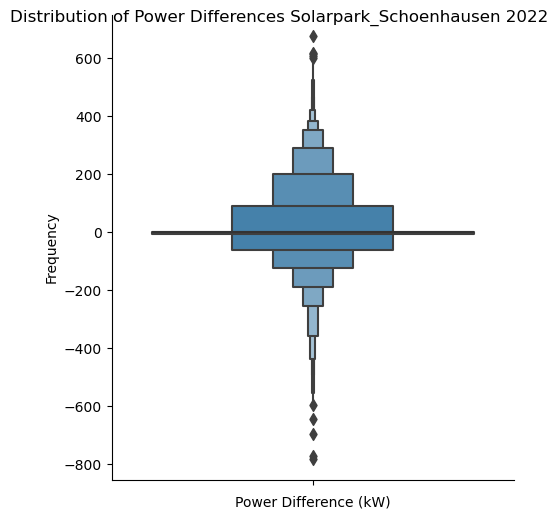

In [ ]:
import seaborn as sns

# create a new column for the power differences
df_power_hist_hourly['power_diff'] = df_power_hist_hourly['real_power'] - scaled_array_power.values

# create a catplot of 'power_diff'
fig3 = sns.catplot(y='power_diff', data=df_power_hist_hourly, kind='boxen')

# set the plot title and axes labels
fig3.fig.suptitle('Distribution of Power Differences '+location+" "+year[0])
fig3.set(xlabel='Power Difference (kW)', ylabel='Frequency')

# show the plot
plt.show()

plot_path = os.path.join(folder_excel_data,'Distribution of Power Differences '+location+" "+year[0]+'.png')
fig3.savefig(plot_path)

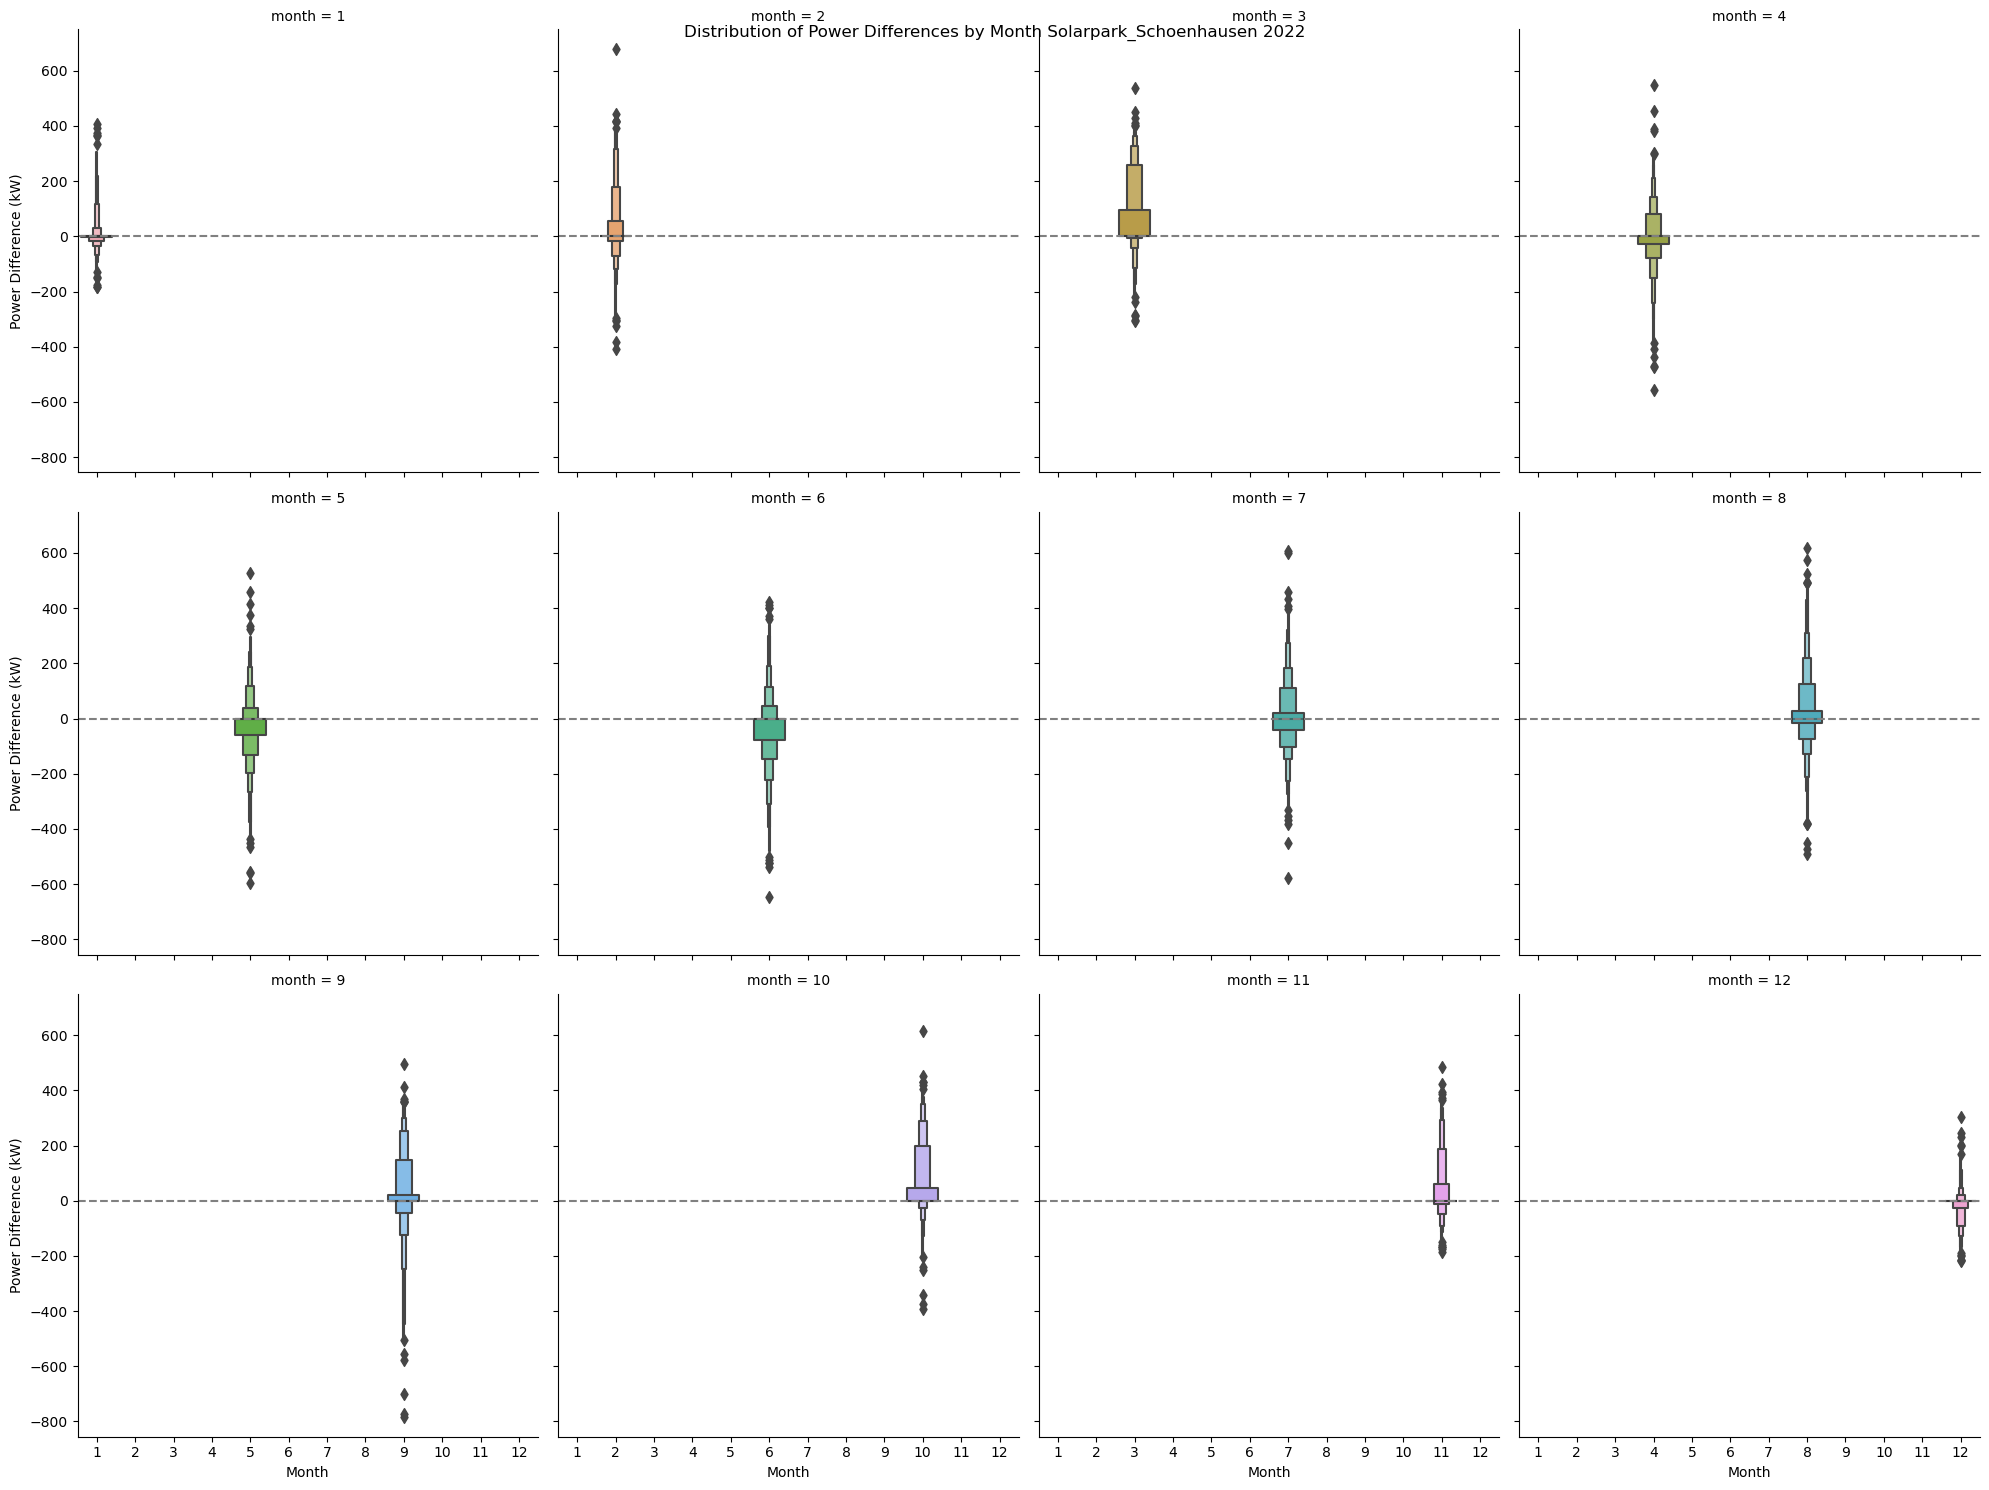

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# extract month from datetime index and create a new column
df_power_hist_hourly['month'] = df_power_hist_hourly.index.month

# create the catplot with 12 panels, one for each month
fig3 = sns.catplot(x='month', y='power_diff', data=df_power_hist_hourly, kind='boxen', col='month', col_wrap=4)

# set the plot title and axes labels
fig3.fig.suptitle('Distribution of Power Differences by Month '+location+" "+year[0])
fig3.set_axis_labels('Month', 'Power Difference (kW)')

# add a horizontal line at y=0 to each plot
for ax in fig3.axes.flat:
    ax.axhline(y=0, color='gray', linestyle='--')

# show the plot
plt.show()

plot_path = os.path.join(folder_excel_data,'Distribution of Power Differences by Month '+location+" "+year[0]+'.png')
fig3.savefig(plot_path)